In [1]:
from peak_warming_calculator import *
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
plt.rc('font', family='serif')

In [2]:
from SALib.sample import saltelli
from SALib.analyze import sobol
import numpy as np
from numpy import genfromtxt

In [3]:
import time

In [4]:
from varying_g_peak_warming_calculator import *

# Varying g peak temperature calculator

In [5]:
consumption_growth_array = np.linspace(0.01, 0.035, 6)
# consumption_growth_array = np.linspace(0.035, 0.035, 1)

In [6]:
consumption_growth_array

array([0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035])

In [7]:
# Define the model inputs
problem_3 = {
'num_vars': 2,
'names': ['P_50/P_100', 'P_100'],
'bounds': [[0.5, 0.8],
[500, 1000]]
}
# Generate samples
param_values_2 = saltelli.sample(problem_3, 8)

In [8]:
P_100_list = []

for i in range(len(param_values_2)):
    P_100_list.append(param_values_2[i][1])

In [9]:
# P_100_list

In [10]:
param_values_2[0][1]

734.375

In [11]:
param_values_2[0][1]*param_values_2[0][0]

387.84179687499994

In [12]:
param_values_2.shape[0]

48

In [13]:
def vary_consumption_growth4(consumption_growth):
    Y = np.zeros([param_values_2.shape[0]])
    SCC_forecasted_0 = np.zeros([param_values_2.shape[0]])
    T_year_list = np.zeros([param_values_2.shape[0]])

#     consumption_growth = 0.020
    consumption_discount = consumption_growth + 0.015

    for i in range(len(param_values_2)):
        if i%8 == 0:
            print(i)
            t = time.localtime()
            current_time = time.strftime("%H:%M:%S", t)
            print(current_time)
        
        P_50 = param_values_2[i][0]*param_values_2[i][1]
        P_100 = param_values_2[i][1]
        r = consumption_discount
        constraint = 2.5  # param_values_2[i][1]
#         s = r * np.log(constraint)/np.log((P_100 - P0)/(P_50 - P0))
        s = r * np.log(constraint)/np.log((P_100)/(P_50))
#         g_grad = 0.0001

        Y[i], SCC_forecasted, forecasted_abatement, forecasted_emissions, T_complete = varying_g_peak_warming_calculator(P_50=P_50, s=s, P_100=P_100, g_2019=consumption_growth, consumption_discount=consumption_discount, r=r, return_all_output=True)
        SCC_forecasted_0[i] = SCC_forecasted[0]
        start_year = 1750
        peak_T = Y[i]
        T_year_list[i] = next(x[0] for x in enumerate(T_complete) if x[1] == peak_T) + start_year
        if Y[i] < 1.4:
            print(param_values_2[i][0])
            print(param_values_2[i][1])
            print(consumption_discount)
#             print(param_values_2[i][2])
    return Y, SCC_forecasted_0, T_year_list

In [14]:
Y_array = []
SCC_0_array = []
T_year_array = []

for i in range(len(consumption_growth_array)):  # len(consumption_growth_array)
    Y, SCC_0, T_year = vary_consumption_growth4(consumption_growth_array[i])
    Y_array.append(Y)
    SCC_0_array.append(SCC_0)
    T_year_array.append(T_year)

0
13:44:50


/Users/aaron/Documents/oxford_physics/Year_4/MPhys/drivers-of-peak-warming/peak_warming_calculator/varying_g_peak_warming_calculator.py:272: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


8
13:46:02
16
13:47:30
24
13:48:55
32
13:50:33
40
13:52:02
0
13:53:32
8
13:54:44
16
13:56:01
24
13:57:21
32
13:58:57
40
14:00:24
0
14:02:00
8
14:03:07
16
14:04:24
24
14:05:34
32
14:06:55
40
14:08:08
0
14:09:26
8
14:10:28
16
14:11:32
24
14:12:31
32
14:13:36
40
14:14:36
0
14:15:38
8
14:16:27
16
14:17:17
24
14:18:08
32
14:19:01
40
14:19:51
0
14:20:44
8
14:21:26
16
14:22:08
24
14:22:53
32
14:23:39
40
14:24:22


Text(0, 0.5, 'Peak Warming')

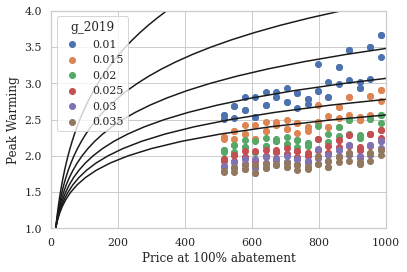

In [17]:
## plot output

for i in range(len(Y_array)):
    plt.scatter(P_100_list, Y_array[i], label=np.round(consumption_growth_array[i], 3))

# plt.legend()
plt.rc('font', family='serif')

## plot curves from Myles' paper

# W0 = 75*10**12  
W0 = 80*10**12  
D0 = 0.00267
T_TCRE = 0.00054  # degrees Celsius per GtCO2
# note: this corresponds to 0.002 degrees Celsius per GtC
r_minus_g = 0.015  # 1.5%
ks = 0.12  # per year

G = W0*D0*T_TCRE*(1/(r_minus_g)-1/(ks+r_minus_g))

gamma = 2
# E_0 = 39  # 2014 level of emissions
# percentage_of_emissions = 0.75  # set here the percentage of emisison
# E_bar = percentage_of_emissions*E_0
E_bar = 0.75*40.040508
# T_0 = 0.9  # 1.0136929156818866  # degrees Celsius
T_0 = 1.0136929156818866

T_m = np.arange(1, 5,0.1)
g_bar = consumption_growth_array  # np.arange(0.035, 0.04, 0.005)

for i in range(len(g_bar)):
    A_B = gamma*G*(T_m**(gamma-1))*np.exp((g_bar[i]/E_bar) * (T_m-T_0)/T_TCRE)
#     print(gamma, G, T_m)
#     print(np.exp((g_bar[i]/E_bar) * (T_m-T_0)/T_TCRE))
    plt.plot(A_B*10**(-9), T_m, color="k")  # convert cost into trillions of dollars # , label=g_bar[i]

plt.legend(title="g_2019")
plt.xlim(0, 1000)
plt.ylim(1, 4)
plt.xlabel("Price at 100% abatement")
plt.ylabel("Peak Warming")

In [18]:
# np.savetxt("parameter_sensitivity_runs/Y_array_varying_g", Y_array, delimiter=",")